In [41]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from itertools import combinations
import itertools
from collections import Counter
import collections
import pandas as pd
import numpy as np
import gudhi as gd

In [42]:
def shortest_path_distance_matrix(g):
    mtx = np.zeros(( len(g), len(g) ))
    all_path = dict(nx.all_pairs_shortest_path_length(g))#This is all-to-all distance matrix for all the graphs.
    # dim = max(all_path.keys())
    # mtx = np.zeros(( dim, dim ))
    vect = DictVectorizer(sparse=False)#Not really sure what this is...?
    for k, v in all_path.items():
        x = vect.fit_transform(v)
        mtx[k-1,:] = x
        #mtx gives a shortest path distance matrix for the graph g.

    unique_elements, counts_elements = np.unique(mtx, return_counts=True)
    unique_elements=unique_elements.astype(int)

    #As we are double counting, I divide here by 2 all except fromthe first
    #entry to give the number of unique paths.
    #number_of_paths = np.zeros( len(counts_elements) )
    counts_elements[0] = counts_elements[0]
    for aa in range(1,len(counts_elements)):
      counts_elements[aa] = int(round(counts_elements[aa]/2))
    #print( "Number of paths : " , counts_elements )

    #OK, so over here we count the number of paths of the length 0, 1, 2 etc.
    #Note that because we have here a symmetric square matrix, the number of
    #paths gets double counted. Therefore, formally we should divide it by 2,
    #but it is not really important for our main purpose here.

    return mtx, unique_elements, counts_elements

In [43]:
def create_vertex_to_edge_map( g,mtx ):
  #Now we need to enumerate all the edges (of length 1) in the tree, as the edges
  #of a unit length will serve as 0 dimensional simplices. For that we create a
  #dictionary having as argument incresingly ordered pair of vertices of a tree,
  #that assign an arbitrary number to that edge. Those numbers will be the
  #vertices of the created complex!
  vertex_to_edge_nr_map = {}
  edg_counter = 0
  for i in range( 1,len(g)+1 ):
    for j in range( i+1 , len(g)+1 ):
      if mtx[i-1,j-1] == 1:
        vertex_to_edge_nr_map[i,j] = edg_counter
        edg_counter = edg_counter+1
  return vertex_to_edge_nr_map

In [44]:
def create_path_simplicial_complex( g , vertex_to_edge_nr_map , maximal_simplex_dimension = 4 ):
  #Now we get all the paths - they will correspond to simplices of various dimension.
  #Since the simplex tree checks redundancy, we can add the same simplex multiple
  #times. We create Gudhi simplicial complex. First we build a simplex tree:
  st = gd.SimplexTree()
  for i in range( 1,len(g)+1 ):
    for j in range( i+1 , len(g)+1 ):
      for path in nx.all_simple_paths(g, source=i, target=j):
        #print( "length : " , len( path ) )
        if ( len(path) <= maximal_simplex_dimension ):         
            path_signature = []
            for aa in range(1,len(path)):
              #print(i,j,aa)
              v1 = path[aa-1]
              v2 = path[aa]
              if v1 > v2:
                v1,v2 = v2,v1
              path_signature.append( vertex_to_edge_nr_map[v1,v2] )
            st.insert( path_signature )
  return st

In [45]:
def compute_betti_numbers( st ):
  st.persistence(persistence_dim_max=True)
  betti_numbers = st.betti_numbers()
  return betti_numbers

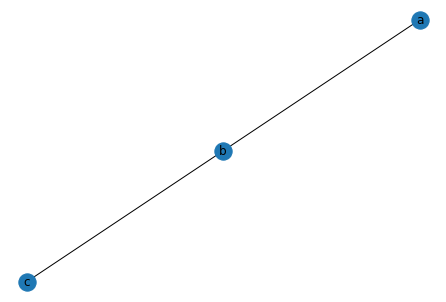

In [46]:
paths_in_graph =[]

G1=nx.Graph()
G2=nx.Graph()

G1.add_nodes_from(['a','b','c'])
G1.add_edges_from([('a','b'),('b','c')])
G2.add_nodes_from(['1','2'])
G2.add_edges_from([('1','2')])
nx.draw(G1, with_labels =True)
plt.show()


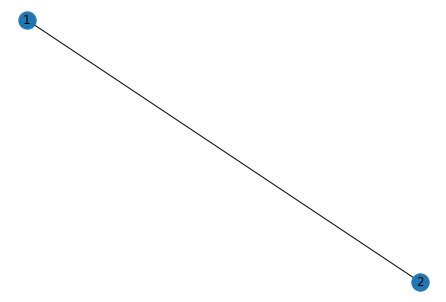

In [47]:
nx.draw(G2, with_labels =True)
plt.show()


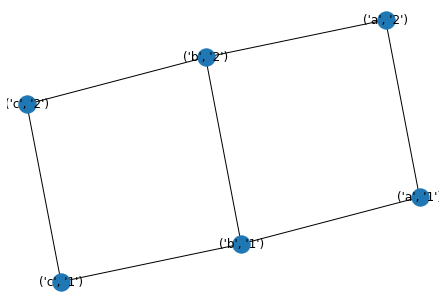

In [48]:
g = nx.cartesian_product(G1, G2)
nx.draw(g, with_labels =True)
plt.show()


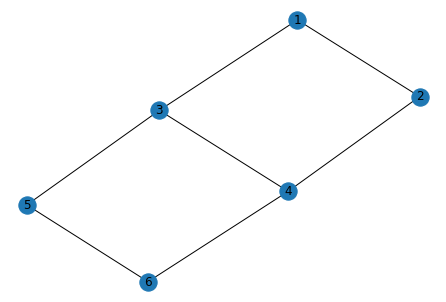

In [49]:
mapping = {('a','1'): 1, ('a','2'): 2,('b','1'): 3, ('b','2'): 4,('c','1'): 5, ('c','2'): 6}
g = nx.relabel_nodes(g, mapping)
nx.draw(g, with_labels =True)
plt.show()

In [50]:
mtx, unique_elements, counts_elements = shortest_path_distance_matrix(g)

In [51]:
v2e = create_vertex_to_edge_map( g,mtx )

In [52]:
cmplx = create_path_simplicial_complex( g , v2e )

In [53]:
number_of_simplices = []
number_of_simplices.append( len(list(cmplx.get_skeleton(0))) )

for aa in range(1,cmplx.dimension()+1):
  number_of_simplices.append( len(list(cmplx.get_skeleton(aa))) - len(list(cmplx.get_skeleton(aa-1))) )


In [54]:
bettis = compute_betti_numbers( cmplx )

In [55]:
print(bettis)

[1, 2, 2]
